<a href="https://colab.research.google.com/github/xyt556/Data/blob/main/Classification_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classification


该脚本基于 Chris Holden 的分类脚本:
来源: [http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html](http://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html)

添加/集成的其他内容:
- 独立验证
- 在预测部分处理内存错误的异常处理
- shp文件作为输入 (Julien Rebetez [https://github.com/terrai/rastercube/blob/master/rastercube/datasources/shputils.py](https://github.com/terrai/rastercube/blob/master/rastercube/datasources/shputils.py))
- report.txt

---


## 数据准备


In [1]:
# 下载文件：用原来的文件名

import gdown

# 共享链接
url = 'https://drive.google.com/uc?id=1Bq9NjJC-YOQL9XDV_ZvUX3PGnPejwzoQ'

# 下载文件并保留原始文件名
gdown.download(url, quiet=False, fuzzy=True)


Downloading...
From (original): https://drive.google.com/uc?id=1Bq9NjJC-YOQL9XDV_ZvUX3PGnPejwzoQ
From (redirected): https://drive.google.com/uc?id=1Bq9NjJC-YOQL9XDV_ZvUX3PGnPejwzoQ&confirm=t&uuid=76927d10-065a-465e-a355-0dbea489cc9e
To: /content/data.zip
100%|██████████| 56.7M/56.7M [00:01<00:00, 38.1MB/s]


'data.zip'

In [2]:
import os
import zipfile   # 解压缩文件需要

# 解压缩函数
def unzip_file(zip_file_path, extract_to_dir=None):
    """
    解压指定的 ZIP 文件到指定目录。如果没有提供目标目录，则解压到ZIP文件所在的目录。

    参数:
    zip_file_path (str): ZIP 文件的路径
    extract_to_dir (str): 解压后的目标目录（可选）。如果未指定，默认为 ZIP 文件所在目录
    """
    if extract_to_dir is None:
        # 如果没有提供目标解压目录，使用ZIP文件的所在目录
        extract_to_dir = os.path.dirname(zip_file_path)

    # 确保目标目录存在
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)

    # 解压 ZIP 文件
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)  # 解压所有文件
        print(f"已解压 '{zip_file_path}' 到 '{extract_to_dir}'")

In [ ]:
# 解压缩
unzip_file('data.zip', '.')

已解压 'data.zip' 到 '.'


In [ ]:
# 删除ZIP文件，释放存储空间
os.remove('data.zip')

### 1 - 需要的库

In [ ]:
# 导入所需的库
from osgeo import gdal, ogr, gdal_array  # 导入GDAL库，用于图像数据的输入输出
import numpy as np  # 导入NumPy库，用于数学运算和数组处理
import matplotlib.pyplot as plt  # 导入Matplotlib库，用于绘图
from sklearn.ensemble import RandomForestClassifier  # 导入随机森林分类器
import pandas as pd  # 导入Pandas库，用于处理大型数据表格
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix  # 导入用于计算准确性评估的度量

import seaborn as sn  # 导入Seaborn库，用于更美观的绘图

import datetime  # 导入datetime库，用于处理日期和时间

# 告诉GDAL抛出Python异常，并注册所有驱动
gdal.UseExceptions()  # 启用GDAL异常
gdal.AllRegister()    # 注册所有可用的GDAL驱动



### 2 - 输入数据

- 这是唯一一个你必须改变的部分。

In [ ]:
# 定义要使用的树的数量（默认 = 500）
est = 500

# 应该使用多少个核心？
# -1 表示使用所有可用核心
n_cores = -1

# 要分类的遥感影像文件路径
img_RS = './data/2017_09_05_stack.tif'

# 训练和验证数据的矢量文件路径（形状文件）
training = './data/cal.shp'  # 训练数据
validation = './data/val.shp'  # 验证数据

# 形状文件中类别的属性名称（类别字段名）
attribute = 'class'

# 分类影像保存的目录：
classification_image = './class_.tif'

# 所有元结果应保存的目录：
results_txt = './results_txt_.txt'


In [ ]:
# 加载训练数据并显示所有形状属性

# model_dataset = gdal.Open(model_raster_fname)  # 该行代码可能用于打开模型栅格数据（目前未使用）
shape_dataset = ogr.Open(training)  # 打开训练数据的形状文件
shape_layer = shape_dataset.GetLayer()  # 获取形状文件的图层

# 提取形状文件中所有属性的名称（字段名）
attributes = []
ldefn = shape_layer.GetLayerDefn()  # 获取图层的定义
for n in range(ldefn.GetFieldCount()):  # 遍历图层中的所有字段
    fdefn = ldefn.GetFieldDefn(n)  # 获取字段定义
    attributes.append(fdefn.name)  # 将字段名添加到属性列表中

# 打印可用的属性
print('Available attributes in the shape file are: {}'.format(attributes))


Available attributes in the shape file are: ['Id', 'class']


### 3 - 数据准备

In [ ]:
# 准备结果文本文件：

# 在结果文本文件中追加随机森林分类的标题
print('Random Forest Classification', file=open(results_txt, "a"))
# 记录当前处理时间
print('Processing: {}'.format(datetime.datetime.now()), file=open(results_txt, "a"))
# 分隔线
print('-------------------------------------------------', file=open(results_txt, "a"))
# 写入路径信息的标题
print('PATHS:', file=open(results_txt, "a"))
# 记录遥感影像路径
print('Image: {}'.format(img_RS), file=open(results_txt, "a"))
# 记录训练形状文件路径
print('Training shape: {}'.format(training), file=open(results_txt, "a"))
# 记录验证形状文件路径
print('Validation shape: {}'.format(validation), file=open(results_txt, "a"))
# 记录所选属性名称
print('      chosen attribute: {}'.format(attribute), file=open(results_txt, "a"))
# 记录分类影像保存路径
print('Classification image: {}'.format(classification_image), file=open(results_txt, "a"))
# 记录报告文本文件路径
print('Report text file: {}'.format(results_txt), file=open(results_txt, "a"))
# 分隔线
print('-------------------------------------------------', file=open(results_txt, "a"))


In [ ]:
# 加载影像数据

# 打开遥感影像数据集，以只读模式打开
img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

# 创建一个空数组，用于存储影像数据
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))

# 遍历每个波段，将其数据读取到图像数组中
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()  # 读取每个波段的数据


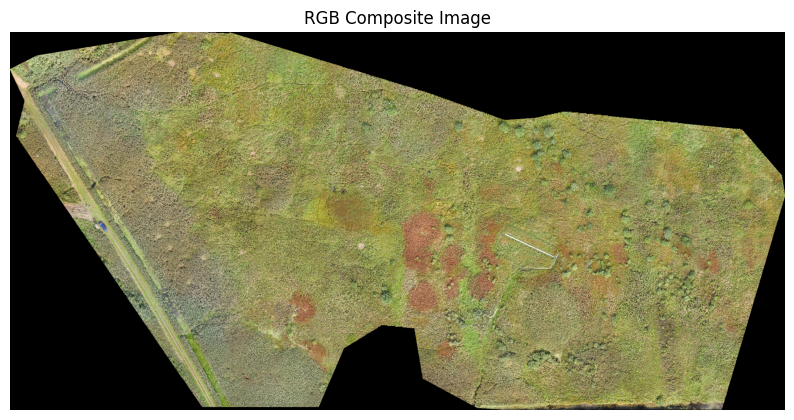

In [ ]:
import matplotlib.pyplot as plt

# 假设红、绿、蓝波段分别为第3、2、1波段（具体的波段索引可以根据您的数据进行调整）
red_band = img[:, :, 2]   # 红色波段
green_band = img[:, :, 1] # 绿色波段
blue_band = img[:, :, 0]  # 蓝色波段

# 将每个波段的值归一化到[0, 1]的范围内（可选）
red_band_normalized = red_band / np.max(red_band)
green_band_normalized = green_band / np.max(green_band)
blue_band_normalized = blue_band / np.max(blue_band)

# 合成彩色图像
rgb_image = np.stack((red_band_normalized, green_band_normalized, blue_band_normalized), axis=-1)

# 显示彩色影像
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title('RGB Composite Image')
plt.axis('off')  # 不显示坐标轴
plt.show()


In [ ]:
!pip install -q rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 32.3 MB/s eta 0:00:00


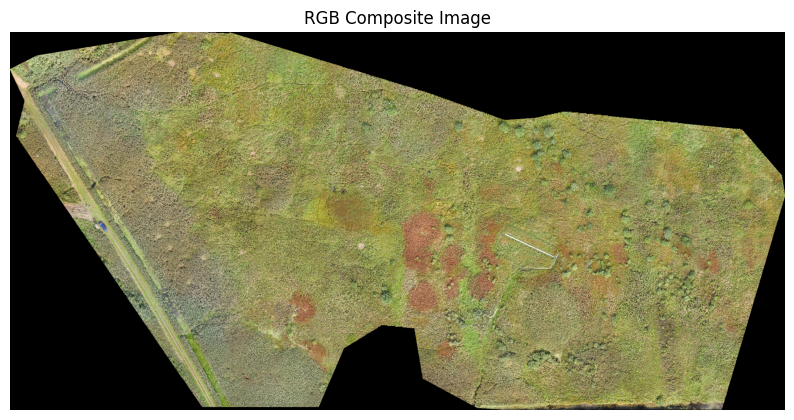

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# 打开遥感影像数据集
with rasterio.open(img_RS) as src:
    # 读取波段数据
    red_band = src.read(3)   # 假设红色波段为第3波段
    green_band = src.read(2) # 假设绿色波段为第2波段
    blue_band = src.read(1)  # 假设蓝色波段为第1波段

# 将每个波段的值归一化到[0, 1]的范围内（可选）
red_band_normalized = red_band / np.max(red_band)
green_band_normalized = green_band / np.max(green_band)
blue_band_normalized = blue_band / np.max(blue_band)

# 合成彩色图像
rgb_image = np.dstack((red_band_normalized, green_band_normalized, blue_band_normalized))

# 显示彩色影像
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.title('RGB Composite Image')
plt.axis('off')  # 不显示坐标轴
plt.show()


In [ ]:
# 获取影像的行数、列数和波段数
row = img_ds.RasterYSize  # 行数（影像高度）
col = img_ds.RasterXSize  # 列数（影像宽度）
band_number = img_ds.RasterCount  # 波段数量

# 打印影像的范围和波段数量
print('Image extent: {} x {} (row x col)'.format(row, col))  # 输出影像的行列数
print('Number of Bands: {}'.format(band_number))  # 输出波段的数量

# 将影像的范围和波段数量写入结果文本文件
print('Image extent: {} x {} (row x col)'.format(row, col), file=open(results_txt, "a"))  # 写入影像行列数
print('Number of Bands: {}'.format(band_number), file=open(results_txt, "a"))  # 写入波段数量
print('---------------------------------------', file=open(results_txt, "a"))  # 分隔符
print('TRAINING', file=open(results_txt, "a"))  # 输出“训练”标题
print('Number of Trees: {}'.format(est), file=open(results_txt, "a"))  # 写入随机森林中的树的数量


Image extent: 1024 x 2098 (row x col)
Number of Bands: 14


In [ ]:
# 从 shapefile 中加载训练数据

#model_dataset = gdal.Open(model_raster_fname)  # 此行注释掉的代码，通常用于打开模型栅格文件
shape_dataset = ogr.Open(training)  # 打开训练数据 shapefile
shape_layer = shape_dataset.GetLayer()  # 获取 shapefile 的图层

# 创建内存栅格驱动
mem_drv = gdal.GetDriverByName('MEM')  # 获取内存驱动
# 创建一个内存栅格，用于存储光栅数据
mem_raster = mem_drv.Create('', img_ds.RasterXSize, img_ds.RasterYSize, 1, gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())  # 设置内存栅格的投影信息
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())  # 设置内存栅格的地理变换信息
mem_band = mem_raster.GetRasterBand(1)  # 获取内存栅格的波段
mem_band.Fill(0)  # 用 0 填充内存波段
mem_band.SetNoDataValue(0)  # 设置无数据值为 0

# 设置要素属性，用于光栅化
att_ = 'ATTRIBUTE=' + attribute
# RasterizeLayer 函数的参考链接
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
# 光栅化 shapefile 中的图层到内存栅格
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1], [att_, "ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None  # 检查光栅化过程是否成功

roi = mem_raster.ReadAsArray()  # 将内存栅格的内容读入数组
roi

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

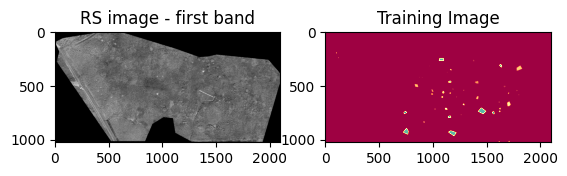

15041 training samples
training data include 11 classes: [ 1  2  3  4  5  6  7  8  9 10 11]
Our X matrix is sized: (15041, 14)
Our y array is sized: (15041,)


In [ ]:
# 显示影像
plt.subplot(121)  # 创建 1 行 2 列的子图，选择第一个子图
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)  # 显示第一波段的遥感影像，使用灰色反转色图
plt.title('RS image - first band')  # 设置子图标题

plt.subplot(122)  # 选择第二个子图
plt.imshow(roi, cmap=plt.cm.Spectral)  # 显示训练图像，使用光谱色图
plt.title('Training Image')  # 设置子图标题

plt.show()  # 显示所有子图

# 训练像素的数量：
n_samples = (roi > 0).sum()  # 统计训练数据中大于 0 的像素数量
print('{n} training samples'.format(n=n_samples))  # 打印训练样本数量
print('{n} training samples'.format(n=n_samples), file=open(results_txt, "a"))  # 将结果写入文本文件

# 我们的分类标签是什么？
labels = np.unique(roi[roi > 0])  # 提取训练数据中独特的类标签
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels))  # 打印类的数量和标签
print('training data include {n} classes: {classes}'.format(n=labels.size, classes=labels), file=open(results_txt, "a"))  # 写入结果文本文件

# 从影像数据集中提取训练图像 = X
# 在训练数据集中掩模类 = y
# 这些将有 n_samples 行
X = img[roi > 0, :]  # 选择 roi 中大于 0 的像素对应的影像数据
y = roi[roi > 0]  # 选择 roi 中大于 0 的像素对应的标签

print('Our X matrix is sized: {sz}'.format(sz=X.shape))  # 打印 X 矩阵的形状
print('Our y array is sized: {sz}'.format(sz=y.shape))  # 打印 y 数组的形状


### 4 - 训练RF模型

In [ ]:
# 创建随机森林分类器
rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=1, n_jobs=n_cores)
# n_estimators: 决策树的数量
# oob_score: 使用袋外样本进行评分
# verbose: 1 表示输出进度信息（0 为不输出，2 为每棵树的进度）
# n_jobs: 使用的核数，-1 表示使用所有可用核

# 如果需要更详细的进度信息，可以将 verbose 设置为 2
# rf = RandomForestClassifier(n_estimators=est, oob_score=True, verbose=2, n_jobs=n_cores)

# 将 X 中的 NaN 值替换为 0
X = np.nan_to_num(X)

# 训练随机森林模型
rf2 = rf.fit(X, y)  # 拟合模型，X 为特征数据，y 为标签


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   20.8s finished


### 5 - RF模型诊断

In [ ]:
# 模型训练完成后，可以检查“袋外” (OOB) 预测得分：
print('--------------------------------', file=open(results_txt, "a"))
print('训练和随机森林模型诊断:', file=open(results_txt, "a"))
print('OOB 预测准确度为: {oob}%'.format(oob=rf.oob_score_ * 100))  # 打印 OOB 预测准确度
print('OOB 预测准确度为: {oob}%'.format(oob=rf.oob_score_ * 100), file=open(results_txt, "a"))

# 显示各波段的重要性
bands = range(1, img_ds.RasterCount + 1)  # 波段范围

# 遍历每个波段和对应的重要性得分
for b, imp in zip(bands, rf2.feature_importances_):
    print('波段 {b} 的重要性: {imp}'.format(b=b, imp=imp))  # 打印波段重要性
    print('波段 {b} 的重要性: {imp}'.format(b=b, imp=imp), file=open(results_txt, "a"))  # 记录到结果文件

# 进行类混淆的交叉表分析
# 导入 Pandas 库以帮助处理
# 设置数据框，就像在 R 中一样
# 异常处理以避免可能的内存错误

try:
    df = pd.DataFrame()  # 创建空数据框
    df['truth'] = y  # 真实标签
    df['predict'] = rf.predict(X)  # 预测标签

except MemoryError:
    print('交叉表不可用')  # 如果内存错误，打印错误信息

else:
    # 交叉表分析预测结果
    print(pd.crosstab(df['truth'], df['predict'], margins=True))  # 打印交叉表
    print(pd.crosstab(df['truth'], df['predict'], margins=True), file=open(results_txt, "a"))  # 记录到结果文件


OOB 预测准确度为: 96.41646167143142%
波段 1 的重要性: 0.026094227695927685
波段 2 的重要性: 0.01749770157719333
波段 3 的重要性: 0.021977782616235605
波段 4 的重要性: 0.03870411709843265
波段 5 的重要性: 0.03230002767681661
波段 6 的重要性: 0.046528707546085145
波段 7 的重要性: 0.05632466117981742
波段 8 的重要性: 0.377015808459616
波段 9 的重要性: 0.11257567618470501
波段 10 的重要性: 0.013860995997362105
波段 11 的重要性: 0.0908952687218046
波段 12 的重要性: 0.02277704358521656
波段 13 的重要性: 0.10256755442021022
波段 14 的重要性: 0.040880427240577


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    1.2s finished


predict    1   2    3     4     5    6    7    8     9    10  11    All
truth                                                                  
1        971   0    0     0     0    0    0    0     0     0   0    971
2          0  49    0     0     0    0    0    0     0     0   0     49
3          0   0  497     0     0    0    0    0     0     0   0    497
4          0   0    0  2836     0    0    0    0     0     0   0   2836
5          0   0    0     0  1050    0    0    0     0     0   0   1050
6          0   0    0     0     0  320    0    0     0     0   0    320
7          0   0    0     0     0    0  818    0     0     0   0    818
8          0   0    0     0     0    0    0  413     0     0   0    413
9          0   0    0     0     0    0    0    0  6914     0   0   6914
10         0   0    0     0     0    0    0    0     0  1087   0   1087
11         0   0    0     0     0    0    0    0     0     0  86     86
All      971  49  497  2836  1050  320  818  413  6914  1087  86

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.7s finished


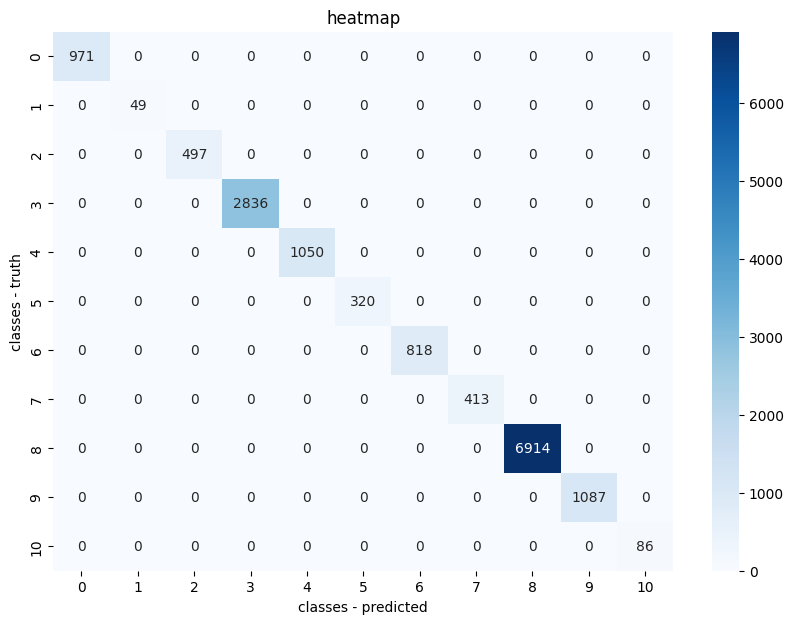

In [ ]:
# 计算混淆矩阵
cm = confusion_matrix(y, rf.predict(X))  # 真实标签与预测标签之间的混淆矩阵

# 设置绘图大小
plt.figure(figsize=(10, 7))

# 使用 seaborn 绘制热力图
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues')  # annot=True 表示在热力图上显示数字, fmt='g' 表示使用整数格式

# 设置 x 轴和 y 轴标签
plt.xlabel('classes - predicted')
plt.ylabel('classes - truth')
plt.title('heatmap')  # 添加标题

# 显示图形
plt.show()


### 5 - 预测

In [ ]:
# 将完整的影像重塑为二维长数组 (nrow * ncol, nband) 以便进行分类
new_shape = (img.shape[0] * img.shape[1], img.shape[2])  # 新的形状: 行数乘以列数，波段数不变
img_as_array = img[:, :, :int(img.shape[2])].reshape(new_shape)  # 重塑数组

print('重塑前形状: {o} -> 重塑后形状: {n}'.format(o=img.shape, n=img_as_array.shape))  # 输出重塑前后的形状

# 替换数组中的 NaN 值为 0
img_as_array = np.nan_to_num(img_as_array)
img_as_array.shape


重塑前形状: (1024, 2098, 14) -> 重塑后形状: (2148352, 14)


(2148352, 14)

In [ ]:
# 现在对每个像素进行预测
# 首先尝试在整个图像上进行预测
try:
    class_prediction = rf.predict(img_as_array)
except MemoryError:
    slices = int(round(len(img_as_array) / 2))  # 初始切片大小
    test = True

    while test:
        try:
            class_preds = []  # 存储预测结果

            # 对第一部分数据进行预测
            temp = rf.predict(img_as_array[0:slices, :])
            class_preds.append(temp)

            # 对剩余数据进行逐片预测
            for i in range(slices, len(img_as_array), slices):
                print('{} % completed, current index: {}'.format((i * 100) / len(img_as_array), i))
                temp = rf.predict(img_as_array[i:i + slices, :])  # 注意切片边界
                class_preds.append(temp)

            # 将预测结果合并为一个一维数组
            class_prediction = np.concatenate(class_preds)

        except MemoryError:
            slices = max(1, int(slices / 2))  # 确保切片大小始终是正整数
            print('Not enough RAM, new slice size = {}'.format(slices))

        else:
            test = False  # 预测成功，无需再分片
else:
    print('Class prediction was successful without slicing!')

# 输出最终预测结果的形状
print('Final class prediction shape:', class_prediction.shape)


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   39.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.4min


Class prediction was successful without slicing!
Final class prediction shape: (2148352,)


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  1.6min finished


In [ ]:
# 将所有切片合并并重新调整形状以匹配原始图像的尺寸
try:
    # 尝试将所有切片的预测结果合并为一个数组
    class_prediction = np.concatenate(class_preds, axis=0)
except NameError:
    # 如果没有进行切片，则输出相应的提示信息
    print('没有进行切片处理！')

# 将合并后的预测结果重新调整为与原始图像相同的形状
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
print('调整回的形状为: {}'.format(class_prediction.shape))



没有进行切片处理！
调整回的形状为: (1024, 2098)


### 6 - 掩膜

- 掩模分类图像（黑色边框 = 0）


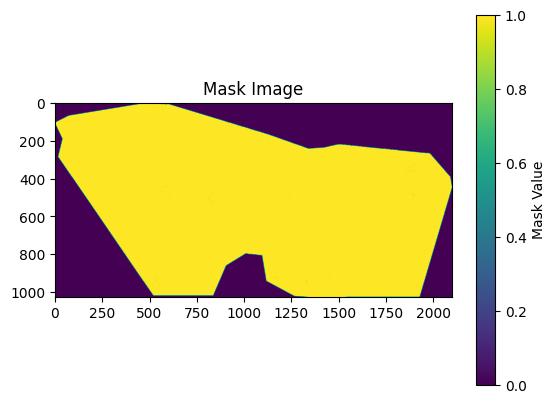

In [ ]:
# 从红色波段生成掩模图像
mask = np.copy(img[:, :, 0])  # 复制红色波段的数据
mask[mask > 0.0] = 1.0  # 所有实际像素的值设为1.0

# 绘制掩模
plt.imshow(mask)  # 使用imshow显示掩模图像
plt.title('Mask Image')  # 添加标题以说明图像内容
plt.colorbar(label='Mask Value')  # 添加颜色条以指示掩模值
plt.show()  # 显示图像


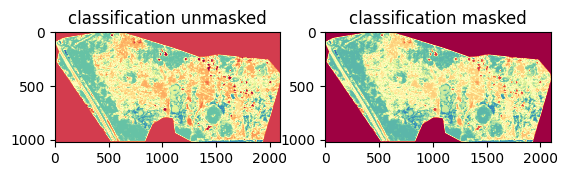

In [ ]:
# 掩模分类并绘制图像

class_prediction.astype(np.float16)  # 将分类结果转换为float16类型以节省内存
class_prediction_ = class_prediction * mask  # 将分类结果与掩模相乘，应用掩模

# 绘制未掩模的分类结果
plt.subplot(121)  # 创建第一个子图
plt.imshow(class_prediction, cmap=plt.cm.Spectral)  # 显示未掩模的分类结果
plt.title('classification unmasked')  # 添加标题，说明图像内容

# 绘制掩模后的分类结果
plt.subplot(122)  # 创建第二个子图
plt.imshow(class_prediction_, cmap=plt.cm.Spectral)  # 显示掩模后的分类结果
plt.title('classification masked')  # 添加标题，说明图像内容

plt.show()  # 显示所有图像


### 7 - 保存分类影像

In [ ]:
cols = img.shape[1]  # 获取图像的列数
rows = img.shape[0]  # 获取图像的行数

class_prediction_.astype(np.float16)  # 将分类结果转换为float16类型以节省内存（注意：未赋值，实际没有改变）

# 创建GeoTIFF驱动
driver = gdal.GetDriverByName("gtiff")  # 获取GeoTIFF格式的GDAL驱动
# 创建输出数据集
outdata = driver.Create(classification_image, cols, rows, 1, gdal.GDT_UInt16)  # 创建一个新的GeoTIFF文件，指定文件名、列数、行数、波段数和数据类型
outdata.SetGeoTransform(img_ds.GetGeoTransform())  # 设置与输入图像相同的地理变换
outdata.SetProjection(img_ds.GetProjection())  # 设置与输入图像相同的投影

# 将分类结果写入输出数据集的波段
outdata.GetRasterBand(1).WriteArray(class_prediction_)  # 将分类结果写入第一波段
outdata.FlushCache()  # 将数据写入磁盘
print('Image saved to: {}'.format(classification_image))  # 打印输出文件保存位置


Image saved to: ./data/class_.tif


### 8 - 精度评价

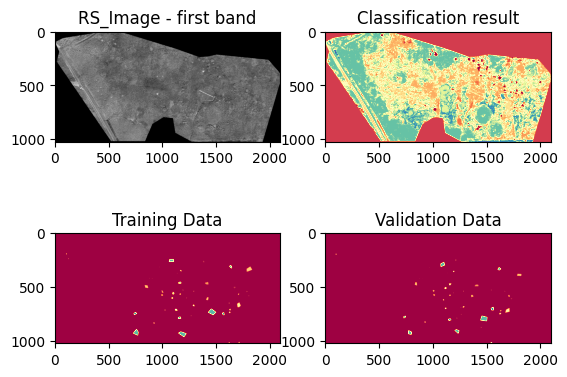

11759 validation pixels
validation data include 11 classes: [ 1  2  3  4  5  6  7  8  9 10 11]
Our X matrix is sized: (11759,)
Our y array is sized: (11759,)
col_0    1   2    3     4     5    6    7    8     9    10  11    All
row_0                                                                
1      462   0    0     0     0    0    0    0   158     0   0    620
2        0  31    0     0     0    0    0    0     0     0   3     34
3        0   0  238   156     0    0    0    5     0    12   0    411
4        0   0   21  1687     0    0    0   72     0    11   0   1791
5        0   0    0    86   904    0    0    0   168    13   0   1171
6        0   0    1    22     0  170    0    0     0    97   0    290
7        0   0    0     0     0    0  490    0     0     0   0    490
8        0   0   24    83     2    0    0  103     0    36   0    248
9       37   0    0     0   195    0    0    0  5256     0   0   5488
10       0   0    6   110    16   44   11    4     0   945   0   1136
11

In [ ]:
# 验证 / 准确度评估

# 准备结果文本文件
print('------------------------------------', file=open(results_txt, "a"))
print('VALIDATION', file=open(results_txt, "a"))

# 从 shapefile 加载验证数据
shape_dataset_v = ogr.Open(validation)  # 打开验证数据的 shapefile
shape_layer_v = shape_dataset_v.GetLayer()  # 获取图层
mem_drv_v = gdal.GetDriverByName('MEM')  # 获取内存驱动
# 创建一个内存栅格以存储验证数据
mem_raster_v = mem_drv_v.Create('', img_ds.RasterXSize, img_ds.RasterYSize, 1, gdal.GDT_UInt16)
mem_raster_v.SetProjection(img_ds.GetProjection())  # 设置与输入图像相同的投影
mem_raster_v.SetGeoTransform(img_ds.GetGeoTransform())  # 设置与输入图像相同的地理变换
mem_band_v = mem_raster_v.GetRasterBand(1)  # 获取第一波段
mem_band_v.Fill(0)  # 填充初始值为 0
mem_band_v.SetNoDataValue(0)  # 设置无数据值为 0

# 栅格化图层到内存栅格
err_v = gdal.RasterizeLayer(mem_raster_v, [1], shape_layer_v, None, None, [1], [att_, "ALL_TOUCHED=TRUE"])
assert err_v == gdal.CE_None  # 确保栅格化没有错误

roi_v = mem_raster_v.ReadAsArray()  # 读取栅格化后的验证数据

# 可视化结果
plt.subplot(221)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)  # 显示遥感图像第一波段
plt.title('RS_Image - first band')

plt.subplot(222)
plt.imshow(class_prediction, cmap=plt.cm.Spectral)  # 显示分类结果
plt.title('Classification result')

plt.subplot(223)
plt.imshow(roi, cmap=plt.cm.Spectral)  # 显示训练数据
plt.title('Training Data')

plt.subplot(224)
plt.imshow(roi_v, cmap=plt.cm.Spectral)  # 显示验证数据
plt.title('Validation Data')

plt.show()

# 统计非零条目的数量，即验证数据样本数量
n_val = (roi_v > 0).sum()  # 计算验证样本数量
print('{n} validation pixels'.format(n=n_val))  # 打印样本数量
print('{n} validation pixels'.format(n=n_val), file=open(results_txt, "a"))  # 保存到结果文本

# 获取验证数据标签
labels_v = np.unique(roi_v[roi_v > 0])  # 获取验证数据中的唯一标签
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v))  # 打印标签信息
print('validation data include {n} classes: {classes}'.format(n=labels_v.size, classes=labels_v), file=open(results_txt, "a"))  # 保存到结果文本

# 根据验证图像子集分类图像 X
# 用于验证数据的类掩码 y
X_v = class_prediction[roi_v > 0]  # 分类图像中的验证样本
y_v = roi_v[roi_v > 0]  # 验证数据的实际样本

print('Our X matrix is sized: {sz_v}'.format(sz_v=X_v.shape))  # 打印 X 矩阵大小
print('Our y array is sized: {sz_v}'.format(sz_v=y_v.shape))  # 打印 y 数组大小

# 交叉制表预测结果
# 混淆矩阵
convolution_mat = pd.crosstab(y_v, X_v, margins=True)  # 生成交叉表
print(convolution_mat)  # 打印混淆矩阵
print(convolution_mat, file=open(results_txt, "a"))  # 保存到结果文本

# 计算精确率、召回率、F1 分数和支持度的信息
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html
target_names = list()  # 存储目标类名
for name in range(1, (labels.size) + 1):
    target_names.append(str(name))  # 添加类名
sum_mat = classification_report(y_v, X_v, target_names=target_names)  # 生成分类报告
print(sum_mat)  # 打印分类报告
print(sum_mat, file=open(results_txt, "a"))  # 保存到结果文本

# 计算总体准确度 (OAA)
print('OAA = {} %'.format(accuracy_score(y_v, X_v) * 100))  # 打印总体准确度
print('OAA = {} %'.format(accuracy_score(y_v, X_v) * 100), file=open(results_txt, "a"))  # 保存到结果文本


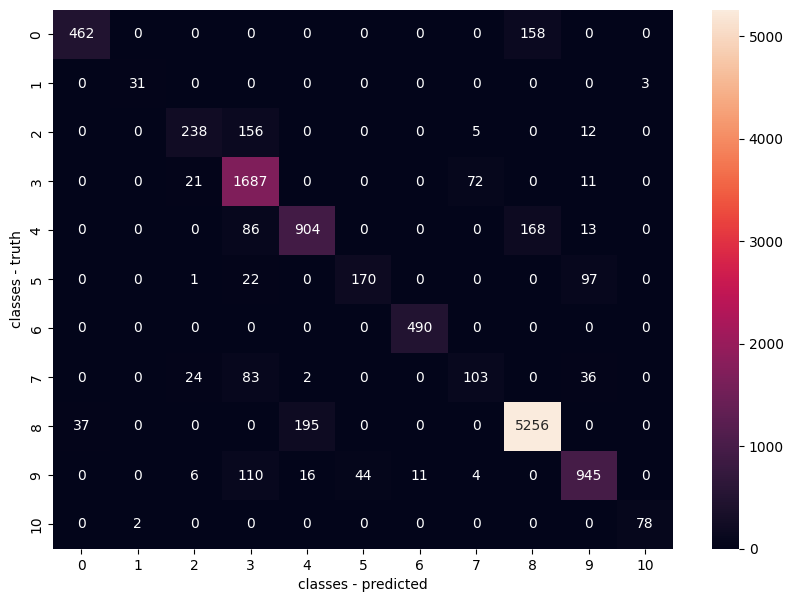

In [ ]:
# 计算验证数据的混淆矩阵
cm_val = confusion_matrix(roi_v[roi_v > 0], class_prediction[roi_v > 0])  # 计算混淆矩阵，真实标签和预测标签
plt.figure(figsize=(10, 7))  # 设置图形的大小
# 绘制热力图以显示混淆矩阵
sn.heatmap(cm_val, annot=True, fmt='g')  # annot=True 显示每个单元格的数值，fmt='g' 指定格式为整数
plt.xlabel('classes - predicted')  # x轴标签：预测类别
plt.ylabel('classes - truth')  # y轴标签：真实类别
plt.show()  # 显示图形
